In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from math import ceil

# Plotting Function

In [37]:
def visualize_network_graph(base_path, runs,plotname):
    # Create a dictionary to hold the dataframes
    dfs = {}
    for run in runs:
        run_number = run.split('.')[0]  # Extract the part of the filename without '.csv'
        dfs[run_number] = pd.read_csv(base_path + run)
        dfs[run_number] = dfs[run_number].drop_duplicates()
    
    graphs = {}
    layer_mapping = {key: i for i, key in enumerate(dfs.keys())}

    # Create graphs for each DataFrame, avoiding self-loops and assigning initial layers
    for key, df in dfs.items():
        G = nx.DiGraph()
        current_layer = layer_mapping[key]
        for i in range(len(df) - 1):
            src = df.iloc[i]['Channel']
            tgt = df.iloc[i + 1]['Channel']
            if src != tgt:
                G.add_node(src, Training=df.iloc[i]['Training'], layer=current_layer)
                G.add_node(tgt, Training=df.iloc[i + 1]['Training'], layer=current_layer)
                G.add_edge(src, tgt)
        graphs[key] = G

    # Combine all individual graphs into a single graph
    combined_graph = nx.compose_all(graphs.values())

    # Calculate the median layer to position 'Training' nodes
    total_layers = list(layer_mapping.values())
    median_layer = ceil(np.median(total_layers))

    # Update the layer for nodes where 'Training' is True to the median layer
    for node, data in combined_graph.nodes(data=True):
        if data.get('Training'):
            data['layer'] = median_layer

    # Apply a hierarchical layout using 'dot'
    pos = graphviz_layout(combined_graph, prog='dot')

    # Spread nodes in the same adjusted layer horizontally to emphasize parallel paths
    layers = {}

    for node, data in combined_graph.nodes(data=True):
        layer = data['layer']
        if layer not in layers:
            layers[layer] = []
        layers[layer].append(node)

    for layer, nodes in layers.items():
        for i, node in enumerate(nodes):
            pos[node] = (layer * 100, pos[node][1] )  


    minimum_distance=150
    # Sorting nodes in each layer by their y-position and adjusting positions if too close
    for layer, nodes in layers.items():
        sorted_nodes = sorted(nodes, key=lambda n: pos[n][1])
        for i in range(1, len(sorted_nodes)):
            current_pos = pos[sorted_nodes[i]][1]
            previous_pos = pos[sorted_nodes[i - 1]][1]
            if current_pos - previous_pos < minimum_distance:
                pos[sorted_nodes[i]] = (pos[sorted_nodes[i]][0], previous_pos + minimum_distance)

    # First pass to find the lowest y-position of training nodes across all layers
    min_y_for_training = float('inf')
    for node, data in combined_graph.nodes(data=True):
        if data['Training'] and pos[node][1] < min_y_for_training:
            min_y_for_training = pos[node][1]

    # Second pass to adjust y-positions for non-training nodes
    adjustment = {}
    for node, data in combined_graph.nodes(data=True):
        if not data['Training']:
            layer = data['layer']
            if layer not in adjustment:
                # Find the highest y-position of non-training nodes in the same layer
                max_y_in_layer = max(pos[n][1] for n in combined_graph.nodes if combined_graph.nodes[n]['layer'] == layer and not combined_graph.nodes[n]['Training'])
                adjustment[layer] = min_y_for_training-300 - max_y_in_layer
            # Apply adjustment
            pos[node] = (pos[node][0], pos[node][1] + adjustment[layer])

    # Determine indegrees and assign shapes
    indegrees = combined_graph.in_degree()
    shapes = [' ', 'o', '^', 'd', 'h','p','*']  # Limited set of shapes for example
    shape_legend = {}

    for node, deg in indegrees:
        if deg > 0:
            shape = shapes[deg % len(shapes)] if deg < len(shapes) else shapes[-1]
            shape_legend[deg] = shape
        else:
            shape = 'o'
        combined_graph.nodes[node]['shape'] = shape


    plt.figure(figsize=(15, 15))
    colors = [
    'skyblue', 'lightgreen', 'purple', 'red', 'grey', 'pink', 'brown',
    'cyan', 'magenta', 'lime', 'olive', 'chocolate', 'coral', 'lightblue',
    'darkgreen', 'lavender', 'maroon', 'navy', 'goldenrod', 'teal'
    ]

    edge_colors = [
    'blue', 'green', 'purple', 'red', 'darkgrey', 'pink', 'brown',
    'cyan', 'magenta', 'lime', 'olive', 'chocolate', 'coral', 'lightblue',
    'darkgreen', 'lavender', 'maroon', 'navy', 'goldenrod', 'teal'
    ]

    # Draw all nodes first
    for node in combined_graph.nodes():
        node_data = combined_graph.nodes[node]
        color = 'orange' if node_data['Training'] else colors[node_data['layer'] % len(colors)]
        shape = node_data['shape']
        nx.draw_networkx_nodes(combined_graph, pos, nodelist=[node], node_color=color, node_shape=shape, node_size=300, alpha=0.6)

    # Draw the graphs, separating calls by node shape
    for i, (key, graph) in enumerate(graphs.items()):
        nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)


    # Draw edges
    nx.draw_networkx_labels(combined_graph, pos, font_color='black', font_size=10)

    # Create a sorted list of legend entries based on indegree
    sorted_legend_entries = sorted(shape_legend.items(), key=lambda item: item[0])
    for deg, shape in sorted_legend_entries:
        plt.scatter([], [], c='gray', alpha=0.6, s=100, marker=shape, label=f'Indegree {deg}')

    plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Node Shapes')

    plt.title(plotname)
    plt.axis('off')
    plt.show()


## Gun-Type

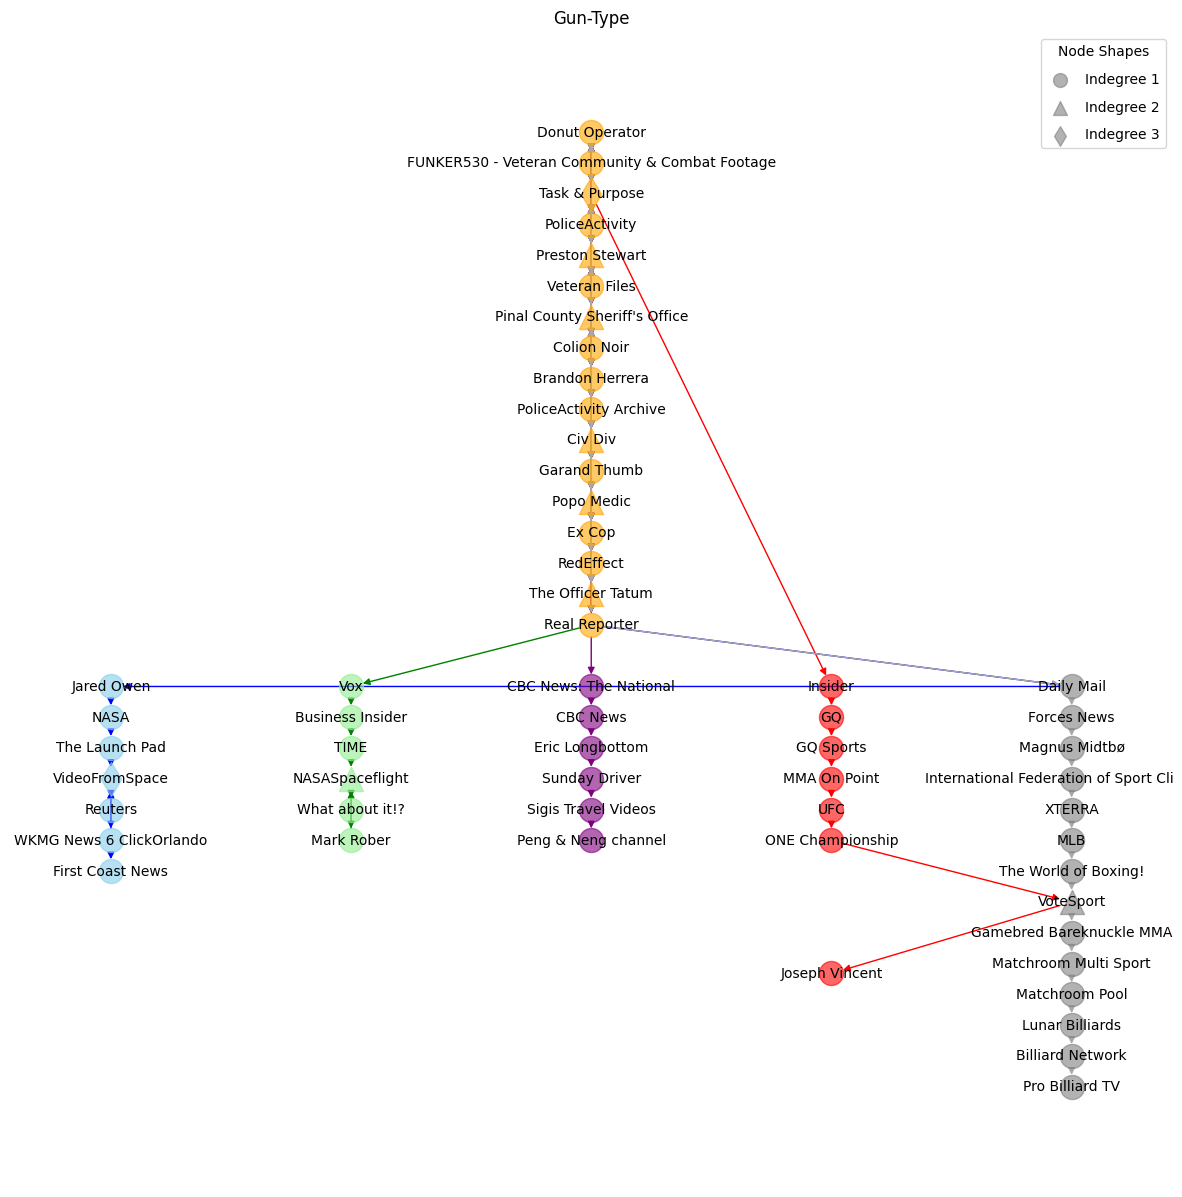

In [38]:
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/Gun-type/'
runs = [ 'run216.csv', 'run219.csv', 'run220.csv', 'run221.csv', 'run222.csv']
name='Gun-Type'
visualize_network_graph(base_path, runs, name)

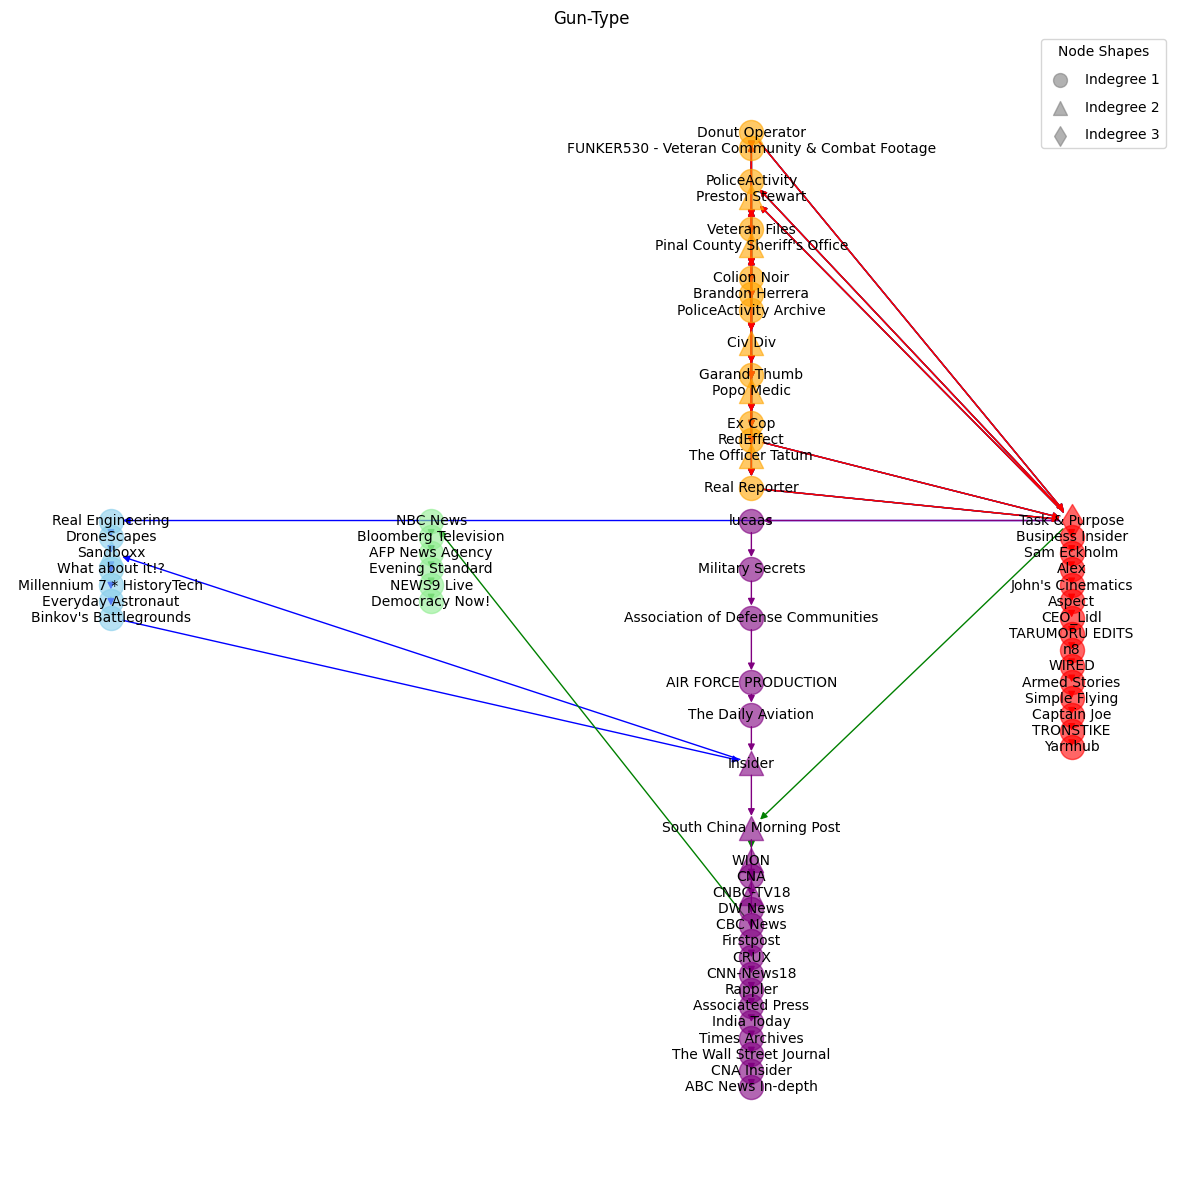

In [9]:

base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/Gun-type/'
runs = ['run28.csv','run46.csv',  'run47.csv', 'run48.csv']
name='Gun-Type'
visualize_network_graph(base_path, runs, name)

## Left

/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12497 (\N{KATAKANA LETTER PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from current font.
  fig.canvas.print_figure(by

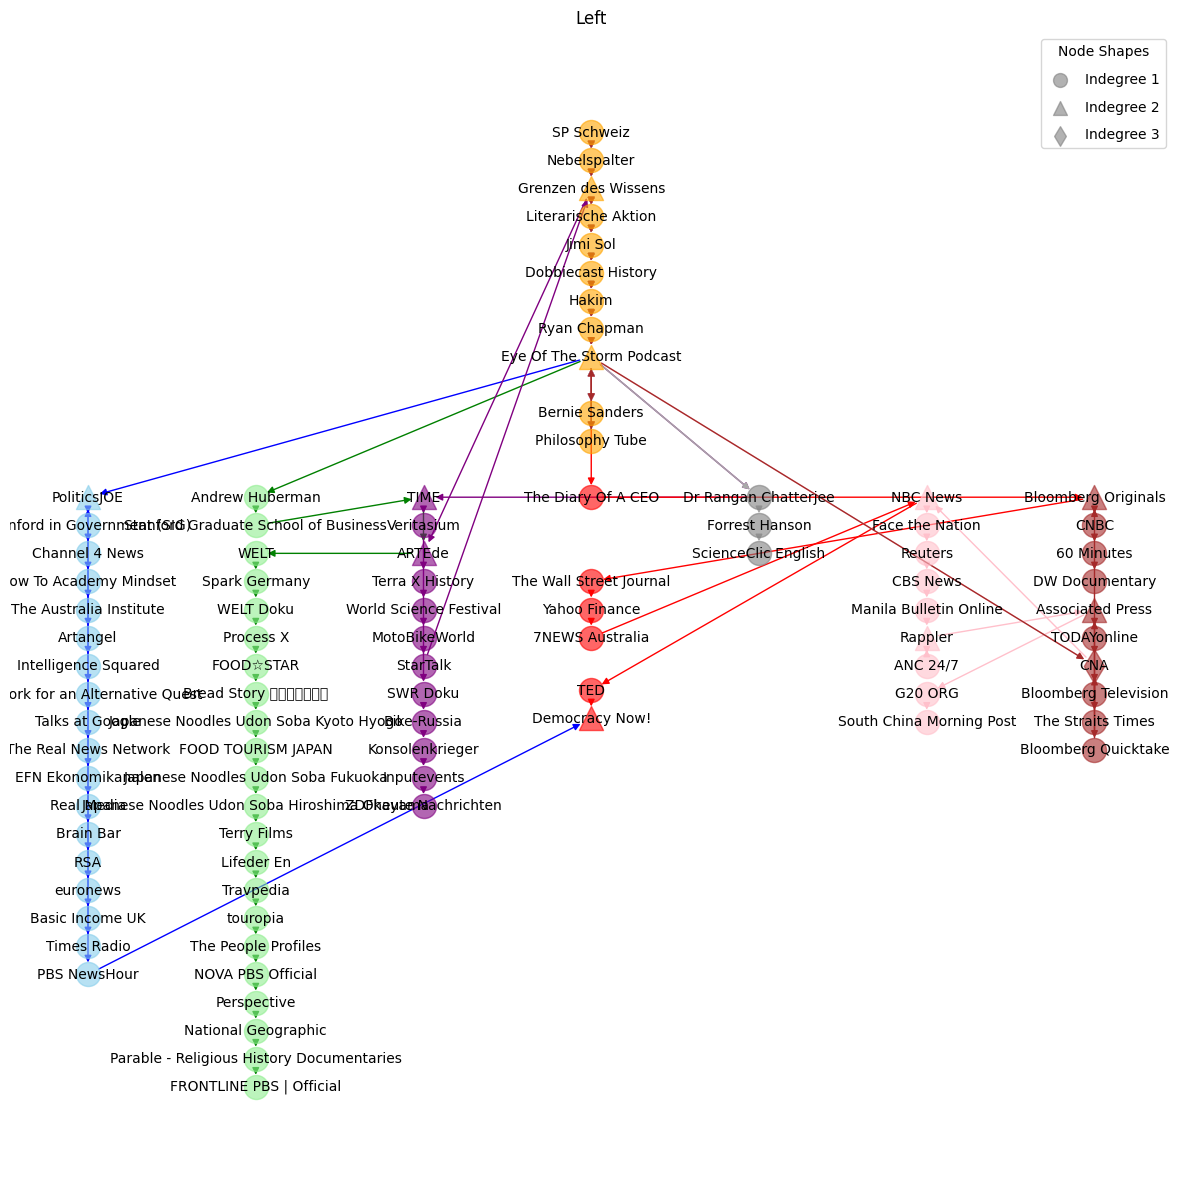

In [10]:

base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/Left/'
runs = ['run224.csv', 'run225.csv', 'run226.csv', 'run227.csv', 'run228.csv', 'run229.csv', 'run230.csv']
name='Left'
visualize_network_graph(base_path, runs, name)

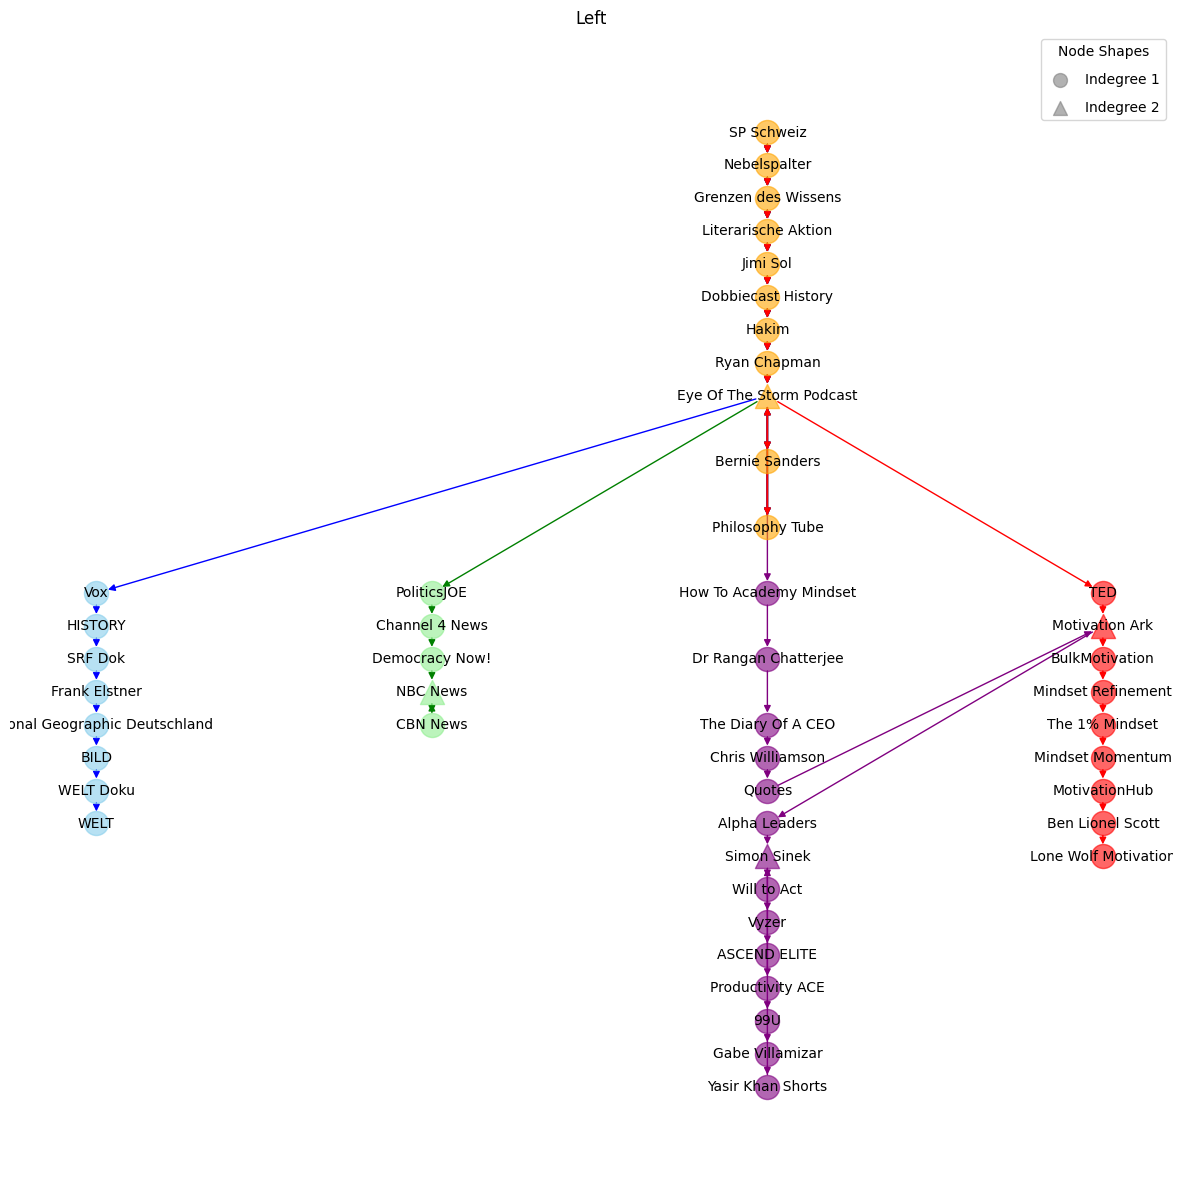

In [11]:

base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/Left/'
runs = ['run32.csv', 'run58.csv', 'run59.csv', 'run60.csv']
name='Left'
visualize_network_graph(base_path, runs, name)

## SVP

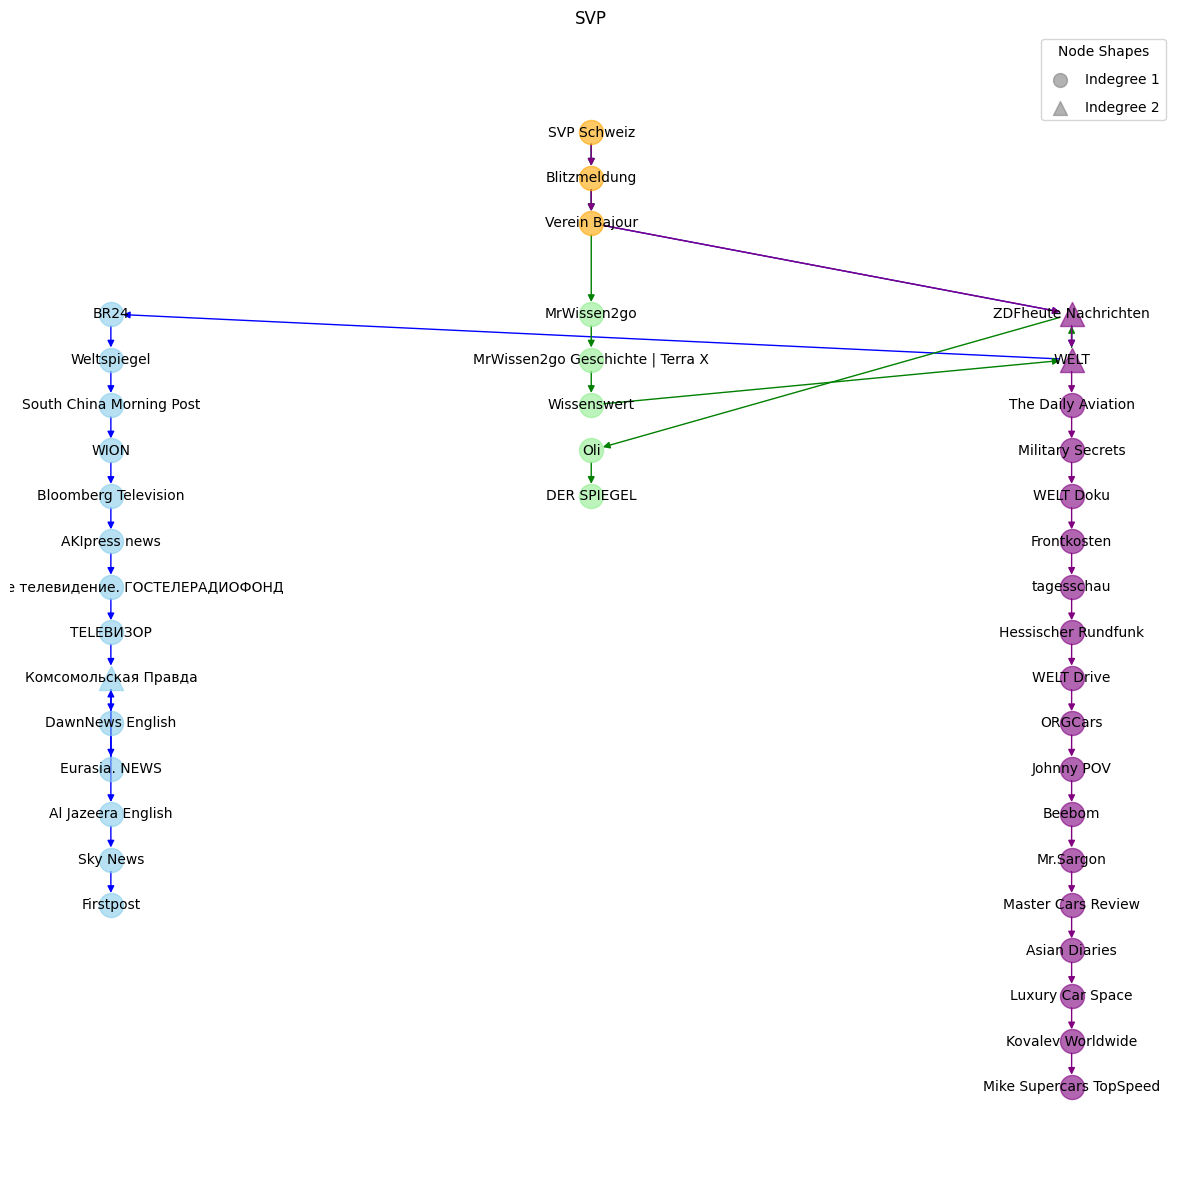

In [13]:
# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/SVP/'
runs = ['run31.csv', 'run55.csv', 'run57.csv']
name='SVP'
visualize_network_graph(base_path, runs, name)

## Pizza

/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23068 (\N{CJK UNIFIED IDEOGRAPH-5A1C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22969 (\N{CJK UNIFIED IDEOGRAPH-59B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27224 (\N{CJK UNIFIED IDEOGRAPH-6A58}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23569 (\N{CJK UNIFIED IDEOGRAPH-5C11}) missing from c

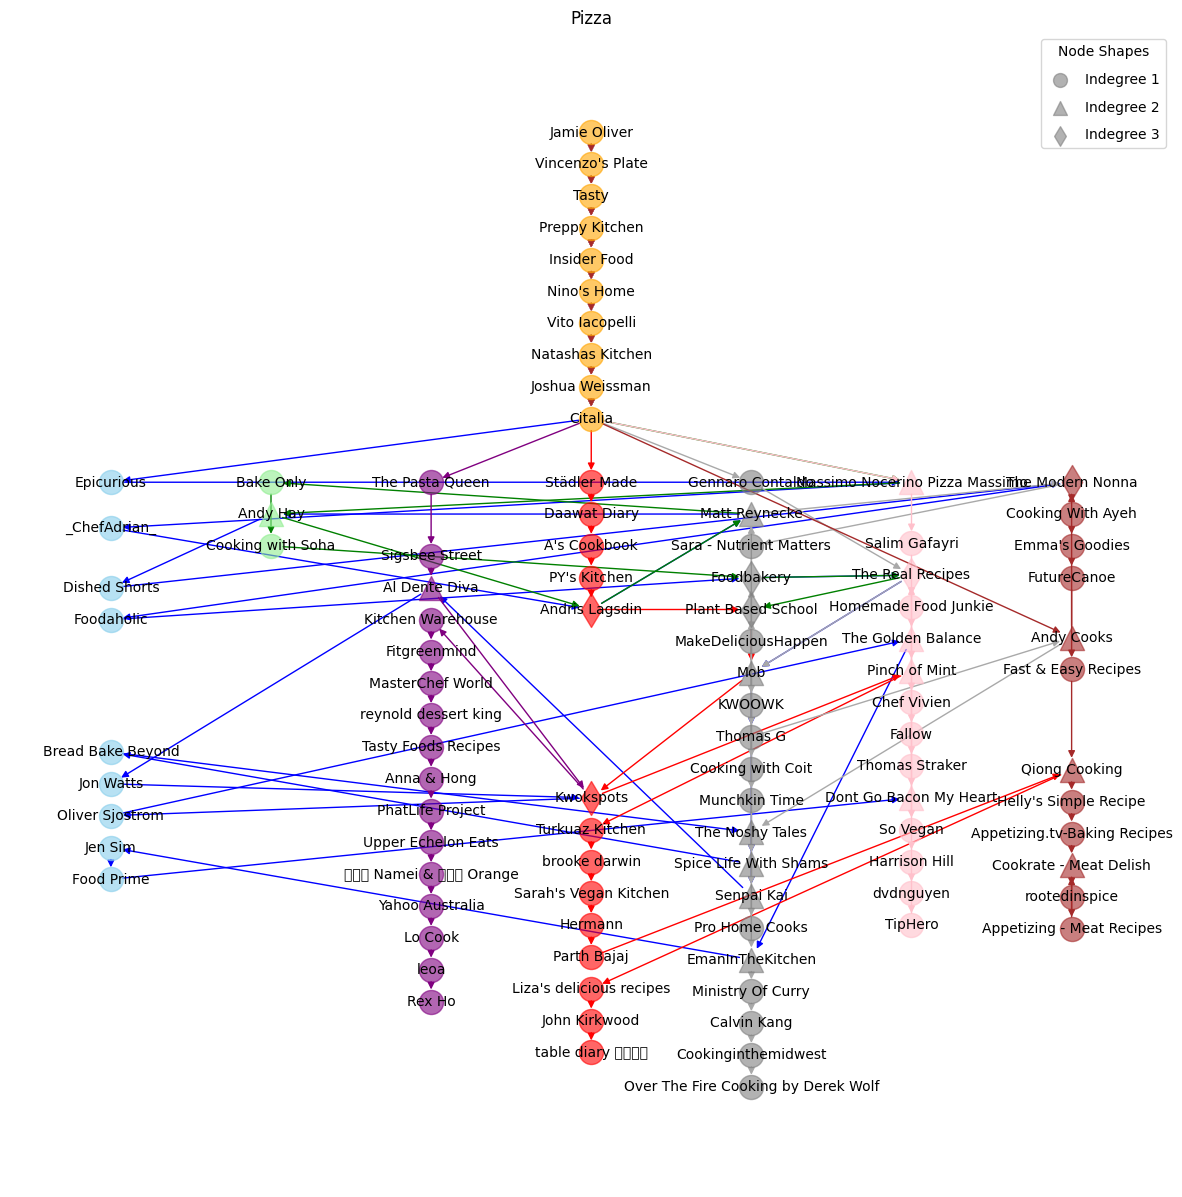

In [14]:
# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/pizza-runs/'
runs = ['run148.csv', 'run149.csv','run150.csv','run151.csv','run152.csv','run153.csv','run154.csv']
name='Pizza'
visualize_network_graph(base_path, runs, name)

## Minecraft

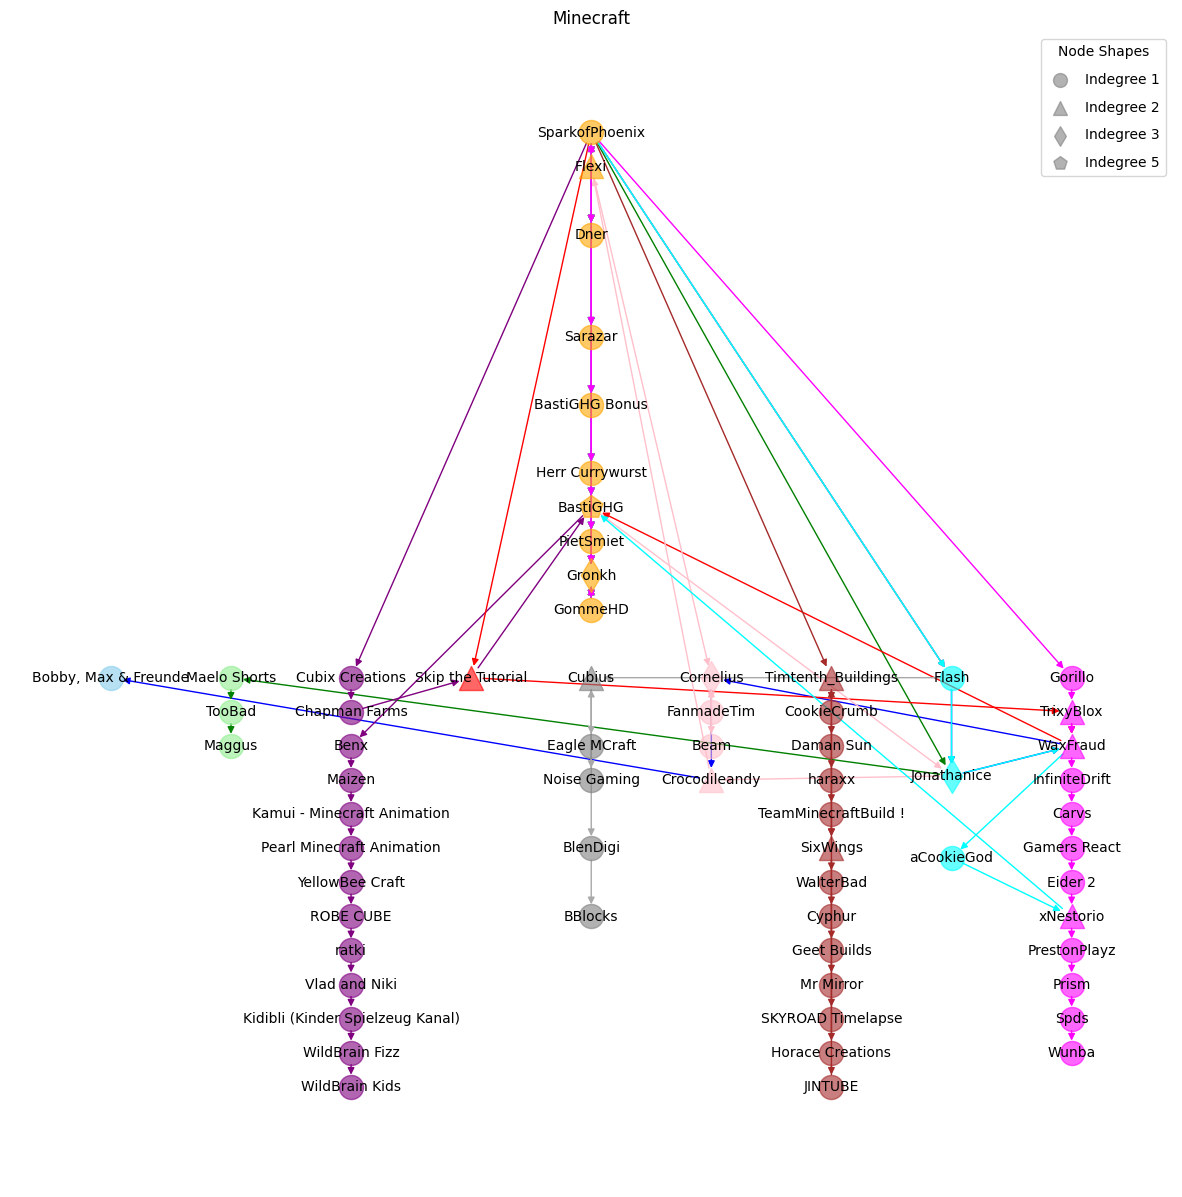

In [18]:
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/Minecraft/'
runs = ['run234.csv', 'run235.csv', 'run236.csv', 'run237.csv', 'run238.csv', 'run239.csv', 'run240.csv', 'run241.csv', 'run242.csv']
name='Minecraft'
visualize_network_graph(base_path, runs, name)

## AFD

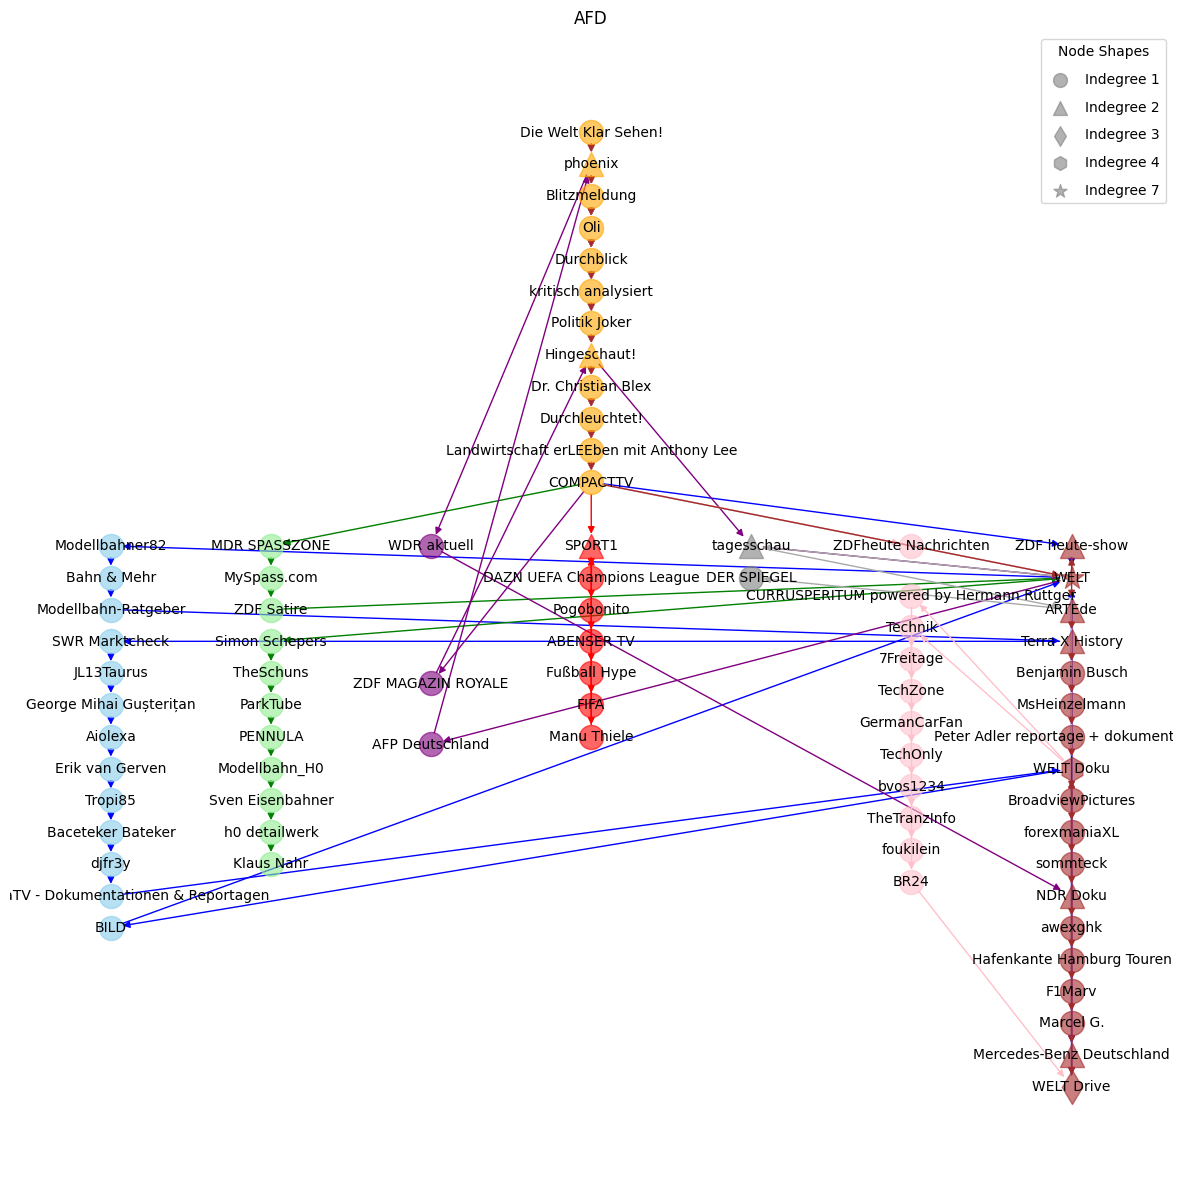

In [24]:
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/AFD/'
runs = ['run208.csv', 'run209.csv', 'run210.csv', 'run211.csv', 'run212.csv', 'run213.csv', 'run214.csv']
name='AFD'
visualize_network_graph(base_path, runs, name)

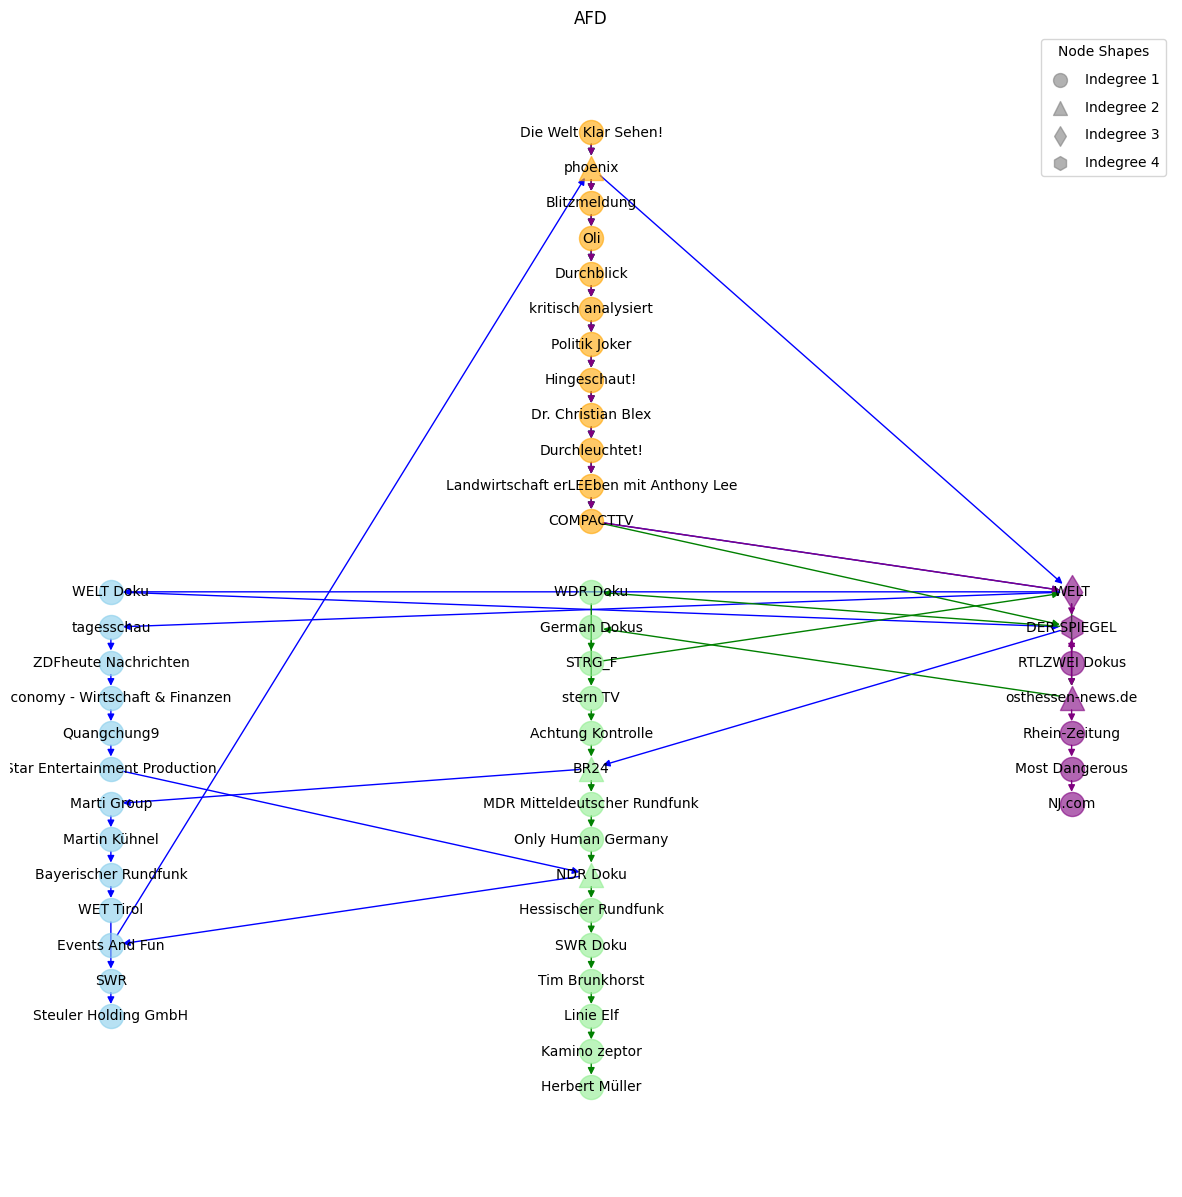

In [25]:
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/AFD/'
runs = ['run52.csv', 'run53.csv', 'run54.csv']
name='AFD'
visualize_network_graph(base_path, runs, name)

## TTT

In [47]:

# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/TTT/'
runs = ['run246.csv', 'run248.csv', 'run249.csv', 'run250.csv', 'run251.csv', 'run252.csv']

# Create a dictionary to hold the dataframes
dfs = {}

# Load each file into the dictionary
for run in runs:
    run_number = run.split('.')[0]  # This will extract the part of the filename without '.csv'
    dfs[run_number] = pd.read_csv(base_path + run)

# Optionally process each dataframe
for df_key in dfs:
    dfs[df_key] = dfs[df_key].drop_duplicates()

# To access and work with a specific dataframe, you can do it by its key:
dfs['run246'].head()

,Unnamed: 0,Title,Channel,url,video_list,Training
0,0,TTT 💀 001: Ich LIEBE dieses Spiel! 😅 ★ Trouble...,Gronkh,https://www.youtube.com/watch?v=amT0GmWrTeo,TTT,True
1,1,PSYCHOSPIELCHEN 💀 TTT #002 ★ Trouble in Terror...,Gronkh,https://www.youtube.com/watch?v=SsS3Sp2BJkc,TTT,True
2,2,Ich bin IMMER unschuldig! 💀 TTT #003 ★ Trouble...,Gronkh,https://www.youtube.com/watch?v=e1tW_F2J_-8,TTT,True
3,3,"TOPI, Du TRECKSSCHWEIN! 💀 TTT #004 ★ Trouble i...",Gronkh,https://www.youtube.com/watch?v=x5NmC9szaeU,TTT,True
4,4,Zu UNRECHT verurteilt! 💀 TTT #005 ★ Trouble in...,Gronkh,https://www.youtube.com/watch?v=z5ZjLQOR0Mg,TTT,True


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


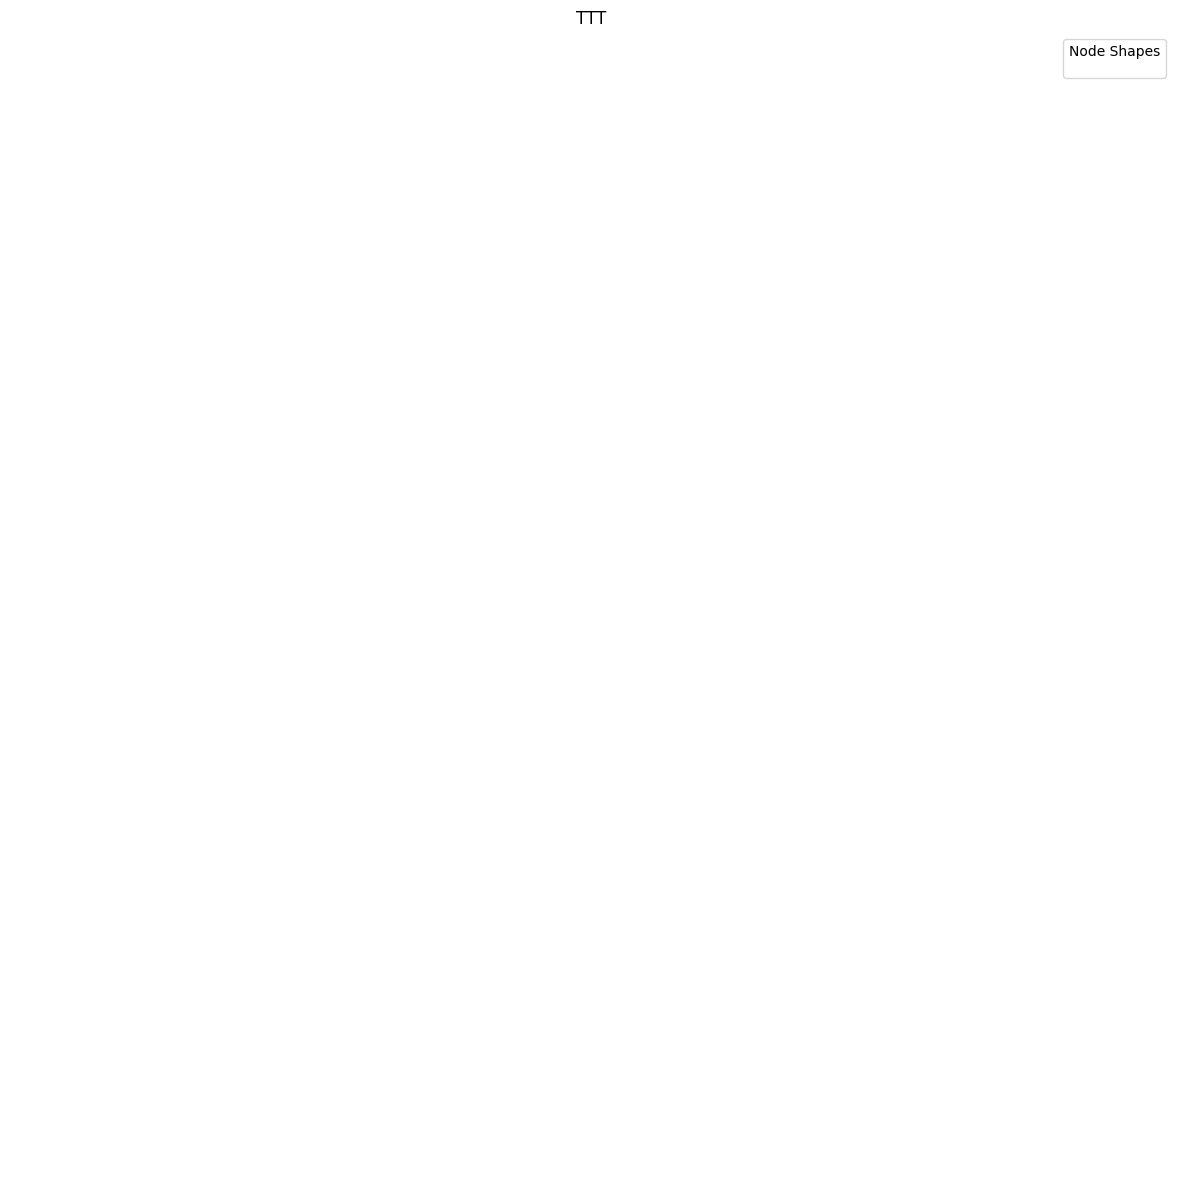

In [48]:
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/TTT/'
runs = ['run246.csv']
name='TTT'
visualize_network_graph(base_path, runs, name)

#, 'run246.csv', 'run248.csv', 'run249.csv', 'run250.csv', 'run251.csv', 'run252.csv'

/home/shutingmi/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:968: RuntimeWarning: invalid value encountered in scalar subtract
  h = maxy - miny


NetworkXError: `self_loop` connection style methodis only to be used for self-loops

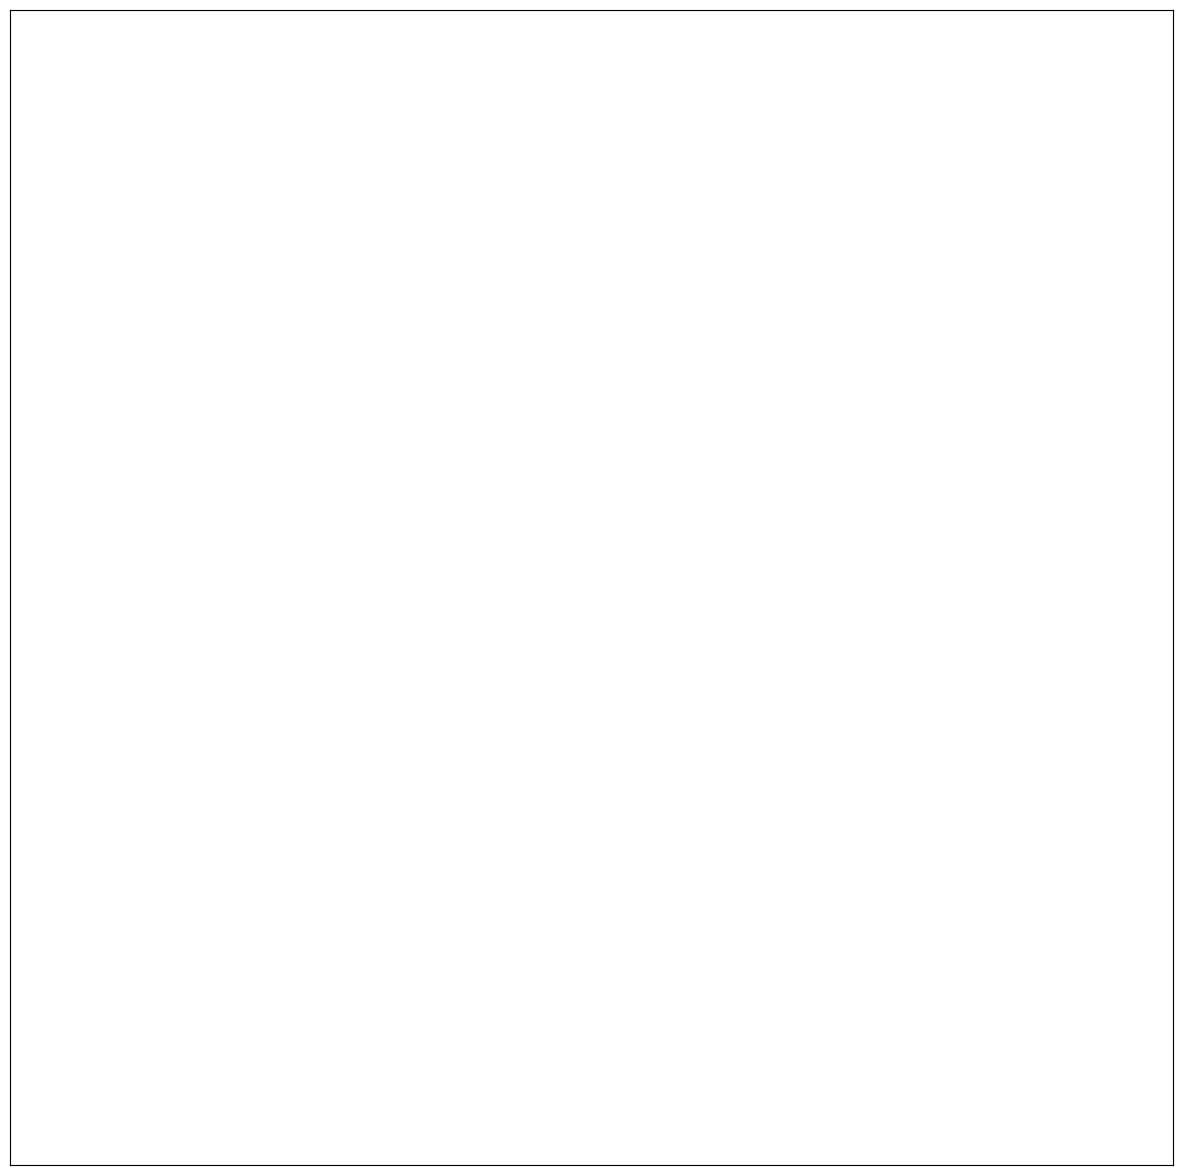

In [49]:
graphs = {}
layer_mapping = {key: i for i, key in enumerate(dfs.keys())}

# Create graphs for each DataFrame, avoiding self-loops and assigning initial layers
for key, df in dfs.items():
    G = nx.DiGraph()
    current_layer = layer_mapping[key]
    for i in range(len(df) - 1):
        src = df.iloc[i]['Channel']
        tgt = df.iloc[i + 1]['Channel']
        if src != tgt:
            G.add_node(src, Training=df.iloc[i]['Training'], layer=current_layer)
            G.add_node(tgt, Training=df.iloc[i + 1]['Training'], layer=current_layer)
            G.add_edge(src, tgt)
    graphs[key] = G

# Combine all individual graphs into a single graph
combined_graph = nx.compose_all(graphs.values())

# Calculate the median layer to position 'Training' nodes
total_layers = list(layer_mapping.values())
median_layer = ceil(np.median(total_layers))

# Update the layer for nodes where 'Training' is True to the median layer
for node, data in combined_graph.nodes(data=True):
    if data.get('Training'):
        data['layer'] = median_layer

# Apply a hierarchical layout using 'dot'
pos = graphviz_layout(combined_graph, prog='dot')

# Spread nodes in the same adjusted layer horizontally to emphasize parallel paths
layers = {}

for node, data in combined_graph.nodes(data=True):
    layer = data['layer']
    if layer not in layers:
        layers[layer] = []
    layers[layer].append(node)

for layer, nodes in layers.items():
    for i, node in enumerate(nodes):
        pos[node] = (layer * 100, pos[node][1] )  


minimum_distance=150
# Sorting nodes in each layer by their y-position and adjusting positions if too close
for layer, nodes in layers.items():
    sorted_nodes = sorted(nodes, key=lambda n: pos[n][1])
    for i in range(1, len(sorted_nodes)):
        current_pos = pos[sorted_nodes[i]][1]
        previous_pos = pos[sorted_nodes[i - 1]][1]
        if current_pos - previous_pos < minimum_distance:
            pos[sorted_nodes[i]] = (pos[sorted_nodes[i]][0], previous_pos + minimum_distance)

# First pass to find the lowest y-position of training nodes across all layers
min_y_for_training = float('inf')
for node, data in combined_graph.nodes(data=True):
    if data['Training'] and pos[node][1] < min_y_for_training:
        min_y_for_training = pos[node][1]

# Second pass to adjust y-positions for non-training nodes
adjustment = {}
for node, data in combined_graph.nodes(data=True):
    if not data['Training']:
        layer = data['layer']
        if layer not in adjustment:
            # Find the highest y-position of non-training nodes in the same layer
            max_y_in_layer = max(pos[n][1] for n in combined_graph.nodes if combined_graph.nodes[n]['layer'] == layer and not combined_graph.nodes[n]['Training'])
            adjustment[layer] = min_y_for_training-300 - max_y_in_layer
        # Apply adjustment
        pos[node] = (pos[node][0], pos[node][1] + adjustment[layer])

# Determine indegrees and assign shapes
indegrees = combined_graph.in_degree()
shapes = [' ', 'o', '^', 'd', 'h','p','*']  # Limited set of shapes for example
shape_legend = {}

for node, deg in indegrees:
    if deg > 0:
        shape = shapes[deg % len(shapes)] if deg < len(shapes) else shapes[-1]
        shape_legend[deg] = shape
    else:
        shape = 'o'
    combined_graph.nodes[node]['shape'] = shape


plt.figure(figsize=(15, 15))
colors = [
'skyblue', 'lightgreen', 'purple', 'red', 'grey', 'pink', 'brown',
'cyan', 'magenta', 'lime', 'olive', 'chocolate', 'coral', 'lightblue',
'darkgreen', 'lavender', 'maroon', 'navy', 'goldenrod', 'teal'
]

edge_colors = [
'blue', 'green', 'purple', 'red', 'darkgrey', 'pink', 'brown',
'cyan', 'magenta', 'lime', 'olive', 'chocolate', 'coral', 'lightblue',
'darkgreen', 'lavender', 'maroon', 'navy', 'goldenrod', 'teal'
]

# Draw all nodes first
for node in combined_graph.nodes():
    node_data = combined_graph.nodes[node]
    color = 'orange' if node_data['Training'] else colors[node_data['layer'] % len(colors)]
    shape = node_data['shape']
    nx.draw_networkx_nodes(combined_graph, pos, nodelist=[node], node_color=color, node_shape=shape, node_size=300, alpha=0.6)

# Draw the graphs, separating calls by node shape
for i, (key, graph) in enumerate(graphs.items()):
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)


# Draw edges
nx.draw_networkx_labels(combined_graph, pos, font_color='black', font_size=10)

# Create a sorted list of legend entries based on indegree
sorted_legend_entries = sorted(shape_legend.items(), key=lambda item: item[0])
for deg, shape in sorted_legend_entries:
    plt.scatter([], [], c='gray', alpha=0.6, s=100, marker=shape, label=f'Indegree {deg}')

plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Node Shapes')

plt.title('TTT')
plt.axis('off')
plt.show()